Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [24]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img


In [25]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#unzip the dataset
#!unzip "/content/gdrive/MyDrive/SkinCancerDataset.zip" > /dev/null

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [26]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [27]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [28]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [29]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [30]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [31]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

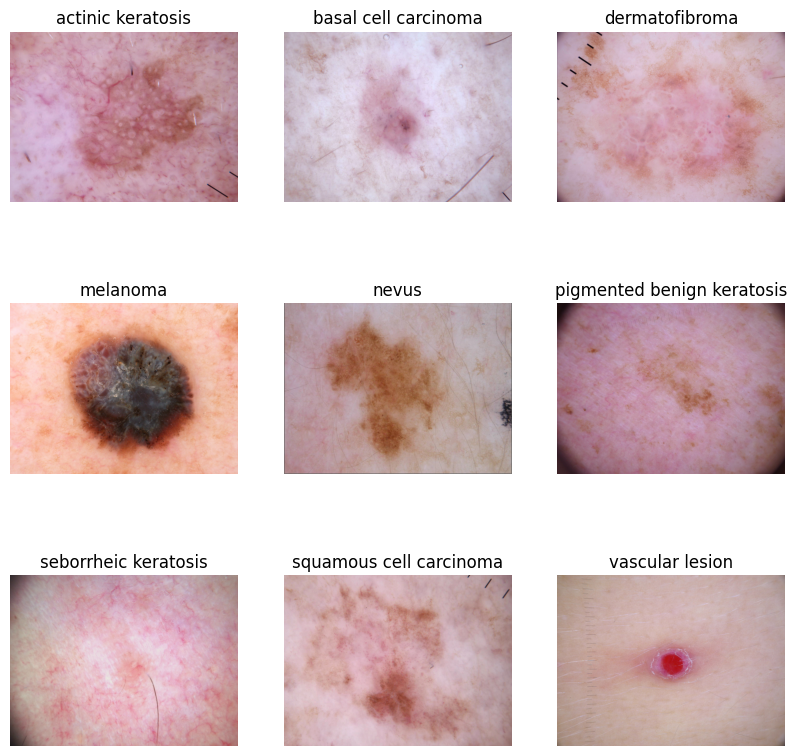

In [32]:
from glob import glob
plt.figure(figsize=(10,10))

for lesion_type in range(class_number):
    class_path = glob(os.path.join(data_dir_train, class_names[lesion_type], '*'))
    lesion_imgs = list(class_path)
    img=PIL.Image.open(str(lesion_imgs[0]))
    ax = plt.subplot(3,3, lesion_type+1)
    plt.imshow(img)
    plt.title(class_names[lesion_type])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [33]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
cached_train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
cached_val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [34]:
# Note the first layer (Rescaling(1./255) rescales the RGB channel values.

num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [35]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 32)       

### Train the model

In [37]:
epochs = 20
history = model.fit(
  cached_train_ds,
  validation_data=cached_val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 18s 44ms/step - loss: 1.9776 - accuracy: 0.2545 - val_loss: 2.4012 - val_accuracy: 0.2609
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.7197 - accuracy: 0.3856 - val_loss: 2.2037 - val_accuracy: 0.3043
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.6755 - accuracy: 0.3890 - val_loss: 2.0965 - val_accuracy: 0.2609
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5737 - accuracy: 0.4291 - val_loss: 2.5999 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4807 - accuracy: 0.4676 - val_loss: 2.5859 - val_accuracy: 0.3043
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4257 - accuracy: 0.5045 - val_loss: 2.5958 - val_accuracy: 0.2609
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3557 - accuracy: 0.5162 - val_loss: 2.6479 - val_accuracy: 0.2609
Epoch 8/20
5

### Visualizing training results

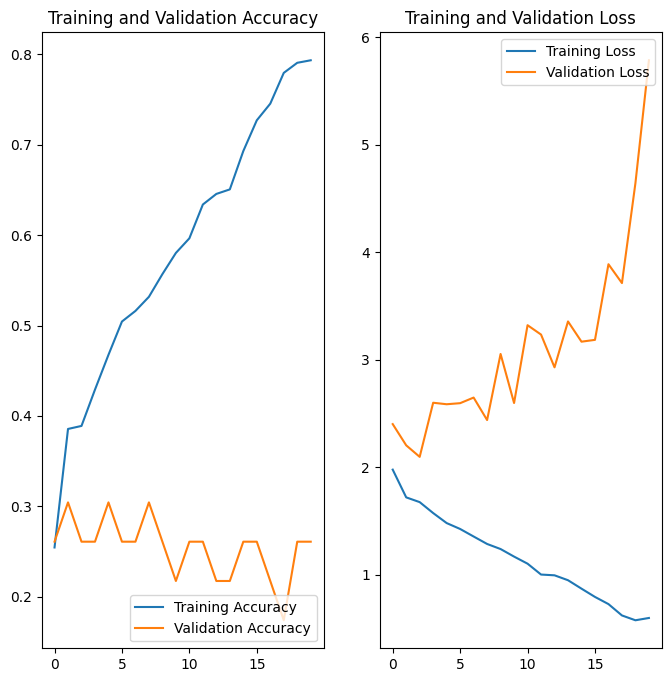

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

There is clearly evidence of overfitting, with the difference between training accuracy and validation accuracy being greater than 0.5. In addition, as can be observed in the graphs above, as training proceeds, while training loss decreases, validation loss increases.

### Write your findings here

In [40]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Creation of data augmentation layer architecture for reuse
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomContrast(0.5),
    layers.RandomBrightness(0.3)
])

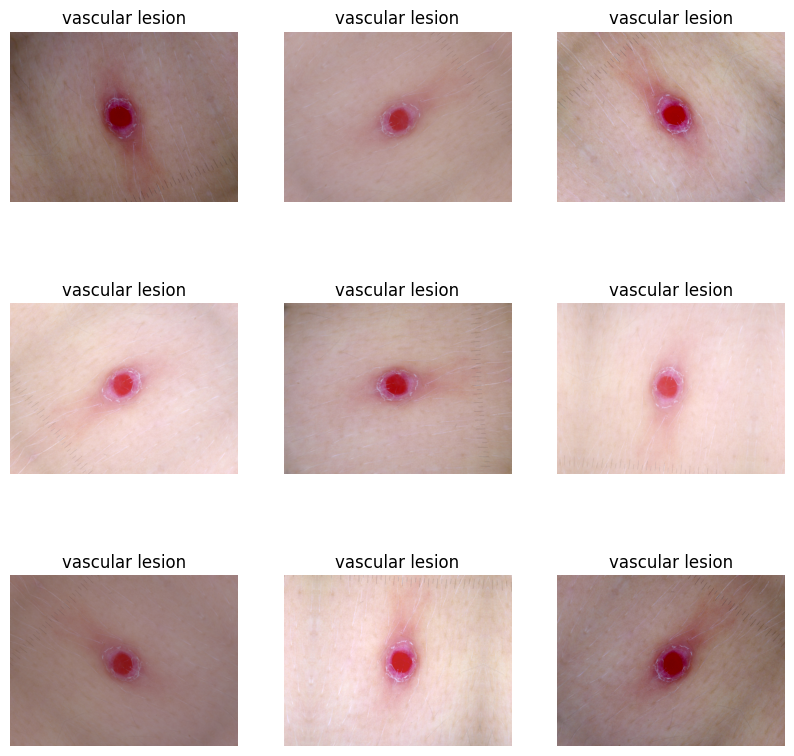

In [41]:
plt.figure(figsize=(10, 10))

for images, labels in cached_train_ds.take(1):
  for i in range(9):
    augmented_image = data_augmentation(img)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.title(class_names[labels[1]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [42]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

# Modify the following variables to experiment with dropout probabilities for different layer types
dropout_conv=0.05
dropout_dense=0.25

model_aug_drop = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(num_classes)
])



### Compiling the model

In [43]:
model_aug_drop.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [44]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20 # As specified in the project pipeline
history = model_aug_drop.fit(
  cached_train_ds,
  validation_data = cached_val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 46ms/step - loss: 1.9680 - accuracy: 0.2656 - val_loss: 2.5323 - val_accuracy: 0.0870
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 1.7218 - accuracy: 0.3917 - val_loss: 2.1340 - val_accuracy: 0.1739
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 1.6725 - accuracy: 0.4152 - val_loss: 2.1522 - val_accuracy: 0.2174
Epoch 4/20
56/56 [==============================] - 2s 44ms/step - loss: 1.6264 - accuracy: 0.4286 - val_loss: 2.0820 - val_accuracy: 0.3043
Epoch 5/20
56/56 [==============================] - 2s 43ms/step - loss: 1.5854 - accuracy: 0.4381 - val_loss: 2.1555 - val_accuracy: 0.3043
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6202 - accuracy: 0.4235 - val_loss: 2.3787 - val_accuracy: 0.2609
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.5197 - accuracy: 0.4537 - val_loss: 2.3706 - val_accuracy: 0.3043
Epoch 8/20
56

### Visualizing the results

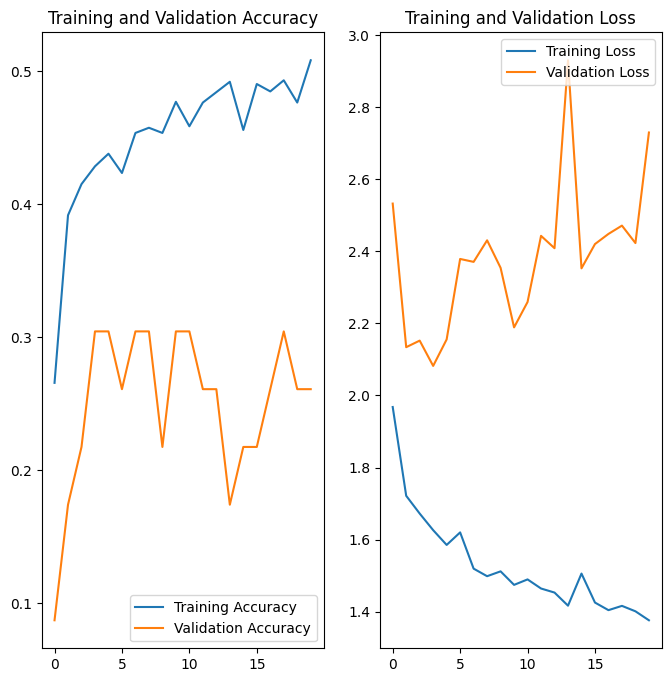

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

As can be seen, the model with augmentation layers and dropouts does not perform better on the training data, actually performing significantly worse. The model still performs poorly during inference using the validation set. There is some improvement, but the model is still overfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [57]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [58]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,actinic keratosis
1,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,actinic keratosis
2,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,actinic keratosis
3,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,actinic keratosis
4,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,vascular lesion
2235,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,vascular lesion
2236,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,vascular lesion
2237,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


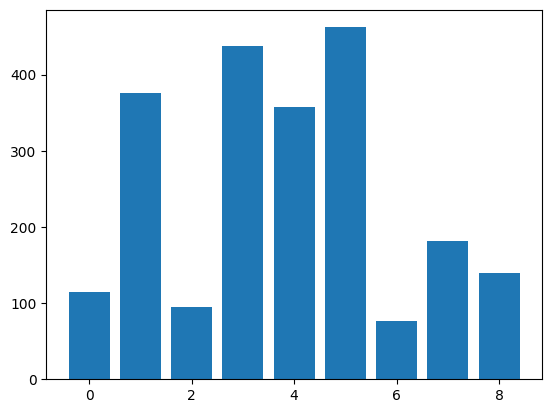

In [59]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [60]:
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# adjustments
count = labels.value_counts().sort_index()
count.index = train_ds.class_names
print(count)

actinic keratosis              92
basal cell carcinoma          309
dermatofibroma                 77
melanoma                      352
nevus                         277
pigmented benign keratosis    370
seborrheic keratosis           58
squamous cell carcinoma       142
vascular lesion               115
dtype: int64


#### **Todo:** Write your findings here:

#### - Which class has the least number of samples?
Seborrheic keratosis has the least number of samples at 58
#### - Which classes dominate the data in terms proportionate number of samples?
The classes with the most samples are: pigmented benign keratosis 370 melanoma 352 basal cell carcinoma 309 nevus 277 Clearly the classes "pigmented benign keratosis" and "melanoma" dominate the data.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [61]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [62]:
#path_to_training_dataset="To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + '/' + str(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C34221CBE80>: 100%|██████████| 500/500 [00:22<00:00, 22.44 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C34222272B0>: 100%|██████████| 500/500 [00:27<00:00, 17.94 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C34221CBD00>: 100%|██████████| 500/500 [00:21<00:00, 23.64 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7C3421101F30>: 100%|██████████| 500/500 [01:14<00:00,  6.74 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C34B1D9EC50>: 100%|██████████| 500/500 [01:20<00:00,  6.24 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C34905A64D0>: 100%|██████████| 500/500 [00:17<00:00, 27.82 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7C34906286D0>: 100%|██████████| 500/500 [00:39<00:00, 12.66 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C3490442380>: 100%|██████████| 500/500 [00:18<00:00, 26.98 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C34B35D66E0>: 100%|██████████| 500/500 [00:17<00:00, 28.67 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [63]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [64]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030344.jpg_bf624b41-5179-44ff-aef6-80b1d1100fcd.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029830.jpg_f7661ebb-53ec-410f-9027-62a1df5677b6.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033413.jpg_a31f00bc-0074-4187-b862-c2270992e5ec.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031430.jpg_385a70f1-5584-4f61-ba33-a38222a67259.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic

In [65]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [66]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [67]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-67-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [68]:
new_df['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [69]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [72]:

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [73]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [74]:
num_classes = 9

model3 = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [75]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [76]:
epochs = 30
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 64s 215ms/step - loss: 1.7396 - accuracy: 0.3288 - val_loss: 1.5632 - val_accuracy: 0.4014
Epoch 2/30
281/281 [==============================] - 61s 215ms/step - loss: 1.2994 - accuracy: 0.5068 - val_loss: 1.1519 - val_accuracy: 0.5607
Epoch 3/30
281/281 [==============================] - 61s 212ms/step - loss: 1.0757 - accuracy: 0.6092 - val_loss: 1.0592 - val_accuracy: 0.6284
Epoch 4/30
281/281 [==============================] - 62s 216ms/step - loss: 0.8481 - accuracy: 0.6964 - val_loss: 1.0134 - val_accuracy: 0.6417
Epoch 5/30
281/281 [==============================] - 61s 212ms/step - loss: 0.6773 - accuracy: 0.7602 - val_loss: 0.6527 - val_accuracy: 0.7579
Epoch 6/30
281/281 [==============================] - 61s 215ms/step - loss: 0.5657 - accuracy: 0.8042 - val_loss: 0.5823 - val_accuracy: 0.7904
Epoch 7/30
281/281 [==============================] - 70s 247ms/step - loss: 0.4200 - accuracy: 0.8552 - val_loss: 0.6318 - val_ac

#### **Todo:**  Visualize the model results

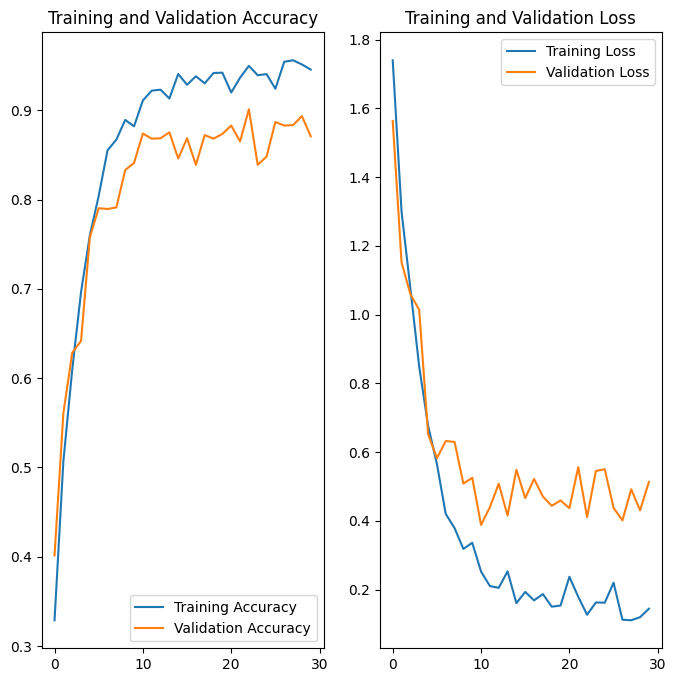

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The results with dataset augmentation have shown significant improvement over previous models, with training accuracy of 0.9456 at 30 epochs, and validation accuracy at 0.8709. Judging by the large fluctuations in the validation loss, it is recommended to rerun the training with a reducing learning rate. The model seems to be jumping around a local minimum.Possibly including a callback to reduce the learning rate once an accuracy of 0.8 has been reached may lead to improvements.